### Initialize Unity communication

In [22]:
import json
import IPython.display
import PIL
import os
os.chdir('../')
from graph_export.scriptcheck import UnityCommunication
comm = UnityCommunication()

In [16]:
comm.reset()

True

In [17]:
pwd

'/Users/xavierpuig'

# Scene start

In [18]:
_, ncameras = comm.camera_count()
print('There are {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-7]
cameras_select = [cameras_select[x] for x in ids]

There are 90 cameras


## Display the scene

In [23]:
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
for img in imgs:
    IPython.display.display(PIL.Image.fromarray(img[:,:,::-1]))
imgs[0].shape

UnityCommunicationException: HTTPConnectionPool(host='127.0.0.1', port=8080): Max retries exceeded with url: / (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x1183d4080>: Failed to establish a new connection: [Errno 61] Connection refused',))

## Switch to new scene

In [33]:
# Rooms 0 to 6
comm.reset(4)

True

There are 79 cameras


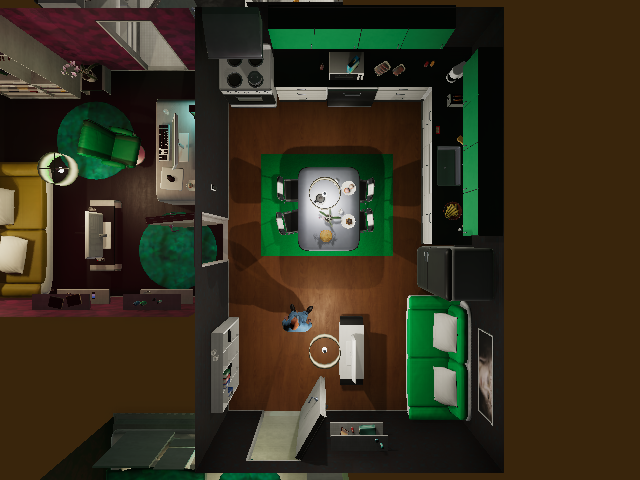

In [34]:
_, ncameras = comm.camera_count()
print('There are {} cameras'.format(ncameras))
cameras_select = list(range(ncameras))
ids = [-10]
cameras_select = [cameras_select[x] for x in ids]
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
for img in imgs:
    IPython.display.display(PIL.Image.fromarray(img[:,:,::-1]))

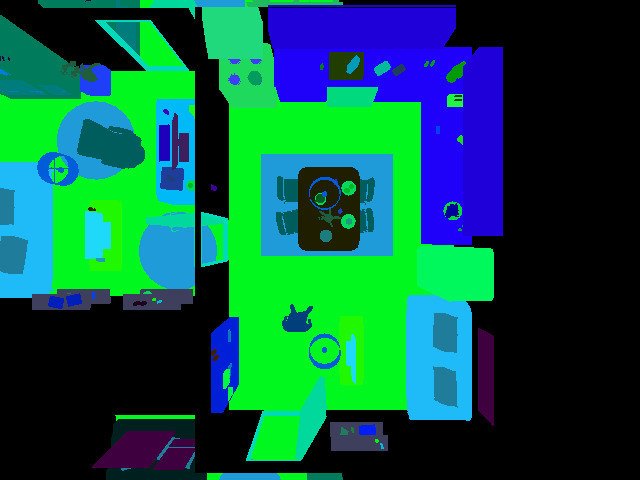

In [35]:
(ok_img, imgs) = comm.camera_image(cameras_select, mode='seg_class')
IPython.display.display(PIL.Image.fromarray(imgs[-1][:,:,::-1]))

# Obtain the current graph

In [36]:
success, graph = comm.environment_graph()

In [37]:
print('Example node')
print(graph['nodes'][0])
print('')
print('Example edge')
print(graph['edges'][0])

Example node
{'id': 1, 'category': 'Rooms', 'class_name': 'livingroom', 'prefab_name': 'PRE_ROO_Livingroom_07', 'bounding_box': {'center': [-0.0313837528, 1.24901164, -1.24998593], 'size': [5.062842, 2.50202322, 5.00004625]}, 'properties': [], 'states': []}

Example edge
{'from_id': 2, 'to_id': 1, 'relation_type': 'INSIDE'}


#### Define some functions for manipulating the environment graph

In [38]:
def find_nodes(graph, **kwargs):
    if len(kwargs) == 0:
        return None
    else:
        k, v = next(iter(kwargs.items()))
        return [n for n in graph['nodes'] if n[k] == v]
    
def find_edges_from(graph, id):
    nb_list = [(e['relation_type'], e['to_id']) for e in graph['edges'] if e['from_id'] == id]
    return [(rel, find_nodes(graph, id=n_id)[0]) for (rel, n_id) in nb_list]

def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}
    

def remove_edges(graph, n, fr=True, to=True):
    n_id = n['id']
    new_edges = [e for e in graph['edges'] if 
                 (e['from_id'] != n_id or not fr) and (e['to_id'] != n_id or not to)]
    graph['edges'] = new_edges

def remove_edge(graph, fr_id, rel, to_id):
    new_edges = [e for e in graph['edges'] if 
                 not (e['from_id'] == fr_id and e['to_id'] == to_id and e['relation_type'] == rel)]
    graph['edges'] = new_edges
    
def add_node(graph, n):
    graph['nodes'].append(n)

def add_edge(graph, fr_id, rel, to_id):
    graph['edges'].append({'from_id': fr_id, 'relation_type': rel, 'to_id': to_id})
    
def clean_graph(graph):
    """
    Remove bounds to reflect real input by Andrew & Xavier
    """
    new_nodes = []
    for n in graph['nodes']:
        nc = dict(n)
        if 'bounding_box' in nc:
            del nc['bounding_box']
        new_nodes.append(nc)
    return {'nodes': new_nodes, 'edges': list(graph['edges'])}



In [39]:
def add_cat(graph):
    graph_1 = clean_graph(graph)
    sofa = find_nodes(graph_1, class_name='sofa')[-2]
    add_node(graph_1, {'class_name': 'cat', 'category': 'Animals', 'id': 1000, 'properties': [], 'states': []})
    add_edge(graph_1, 1000, 'ON', sofa['id'])
    return graph_1

## Add object and view

In [40]:
comm.reset()
success, graph = comm.environment_graph()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)

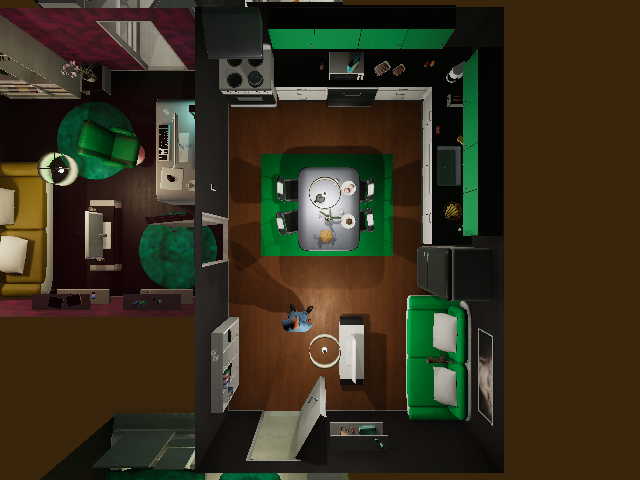

In [41]:
_, ncameras = comm.camera_count()
cameras_select = list(range(ncameras))
cameras_select = [cameras_select[-10]]
(ok_img, imgs) = comm.camera_image(cameras_select, mode='normal')
IPython.display.display(PIL.Image.fromarray(imgs[-1][:,:,::-1]))

# Generating Scripts

In [7]:
script = ['[Walk] <table> (1)']
success, message = comm.render_script(script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      image_width=1280, image_height=960,
                                      camera_mode='FIRST_PERSON')

List of action
- Open
- Close
- SwitchOn
- SwitchOff
- PutBack
- PutIn
- Drink
- Talk
- Text
- Grab
- Sit
- StandUp
- Walk
- Run
- TurnTo
- PointAt
- LookAt
- Find
- Touch

Paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [5]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      camera_mode='PERSON_TOP')

NameError: name 'add_cat' is not defined

In [34]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
script = ['[Walk] <cat> (1)', '[Grab] <cat> (1)']
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=True, 
                                      camera_mode='FIRST_PERSON')

UnityCommunicationException: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response',))

In [16]:
comm.reset()
graph_1 = add_cat(graph)
success, message = comm.expand_scene(graph_1)
id_cat = [x for x in graph_1['nodes'] if x['class_name'] == 'cat'][0]['id']
id_table = [x for x in graph_1['nodes'] if x['class_name'] == 'kitchentable'][0]['id']


In [17]:

script = ['[Walk] <cat> ({})'.format(id_cat), 
          '[Grab] <cat> ({})'.format(id_cat),
          '[Walk] <kitchentable> ({})'.format(id_table),
          '[PutBack] <cat> ({}) <kitchentable> ({})'.format(id_cat, id_table)]
success, message = comm.render_script(frame_rate=10, 
                                      script=script, 
                                      capture_screenshot=True, 
                                      find_solution=False, 
                                      camera_mode='PERSON_TOP')

UnityEngineException: (408, {'id': '1552234949.509575', 'success': False, 'message': 'Timeout', 'value': 0, 'message_list': None})

### Examples - tested  to work on scene 7!

#### Grab mug, go to toilet, sit on toilet, open fridge

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

In [ ]:
mug_id = find_nodes(graph, class_name='mug')[0]['id']
toilet_id = find_nodes(graph, class_name='toilet')[0]['id']
fridge_id = find_nodes(graph, class_name='fridge')[0]['id']

Use ids from environment graph, do not let Unity to find a solution

In [ ]:
script = ['[Walk] <mug> ({})'.format(mug_id), 
          '[Grab] <mug> ({})'.format(mug_id),
          '[Walk] <toilet> ({})'.format(toilet_id),
          '[Sit] <toilet> ({})'.format(toilet_id),
          '[Walk] <fridge> ({})'.format(fridge_id),
          '[Open] <fridge> ({})'.format(fridge_id)]          
success, message = comm.render_script(script=script, capture_screenshot=True, find_solution=False, camera_mode='PERSON_FRONT')

#### Put tv on table (prepare scene only, no rendering)

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

In [ ]:
graph_1 = clean_graph(graph)
table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tv', 'category': 'Electronics', 'id': 1000, 
            'properties': ['HAS_SWITCH', 'LOOKABLE', 'HAS_PLUG'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])

In [ ]:
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Note new option __ignore_placing_obstacles__ which allows an object to be put even if it collides with other object on the destination

#### Put a lamp on a table, turn it on, turn other lights off (scene preparation example)

In [ ]:
comm.reset()
success, graph = comm.environment_graph()

Put a lamp to kitchen table with initial state set to "off"

In [ ]:
graph_1 = clean_graph(graph)

table = find_nodes(graph_1, class_name='kitchentable')[0]
new_node = {'class_name': 'tablelamp', 'category': 'Lamps', 'id': 1000, 
            'properties': ['HAS_SWITCH'], 'states': ['OFF']}
add_node(graph_1, new_node)
add_edge(graph_1, 1000, 'ON', table['id'])
success, message = comm.expand_scene(graph_1, ignore_placing_obstacles=True)

Turn off all lights

In [ ]:
graph_2 = clean_graph(graph_1)
lsws = find_nodes(graph_2, class_name='lightswitch')
for ls in lsws:
    ls['states'] =  ['OFF']
success, message = comm.expand_scene(graph_2)

Turn on the lamp

In [ ]:
graph_3 = clean_graph(graph_2)
tlamps = find_nodes(graph_3, id=1000)
for ls in tlamps:
    ls['states'] =  ['ON']
success, message = comm.expand_scene(graph_3)